# Introduction : 
The following notebook investigates the results of different machine learning models (namely linear svm, polynomial svm and random forests)for a binary classification of single cell expression data. The difficulty behind this task resides in the type of data. Indeed genetic data are of high volume and higher complexity as they capture tens of thousands of genes which can be crucial or useless to the task based on the pathology at hands. To gain a better understanding of the data, this work was partially inspired by applications of machine learning to the medical and biological field.

## 0. Import dependencies & load data

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.svm import SVC
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [ ]:
final_test_df=pd.read_csv('/content/ML-A5-2022_test.csv', index_col=0)

ParserError: ignored

In [ ]:
work_df=pd.read_csv('/content/ML-A5-2022_train.csv',index_col=0)

In [ ]:
print(f" final test data is of shape {final_test_df.shape}")

In [ ]:
print(f" used train data is of shape {work_df.shape}")

 used train data is of shape (1000, 34980)


In [ ]:
final_test_df.head()

,A1BG,A1CF,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AACS,...,ZSWIM8-AS1,ZSWIM9,ZUP1,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZZEF1,hsa-mir-423
C-1001,0.0,0.0,low,NaN,low,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,low,NaN,0.0,0.0,0.0,0.0,high,0.0
C-1002,0.0,0.0,low,0.0,low,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,low,0.0,NaN,NaN,0.0,0.0,medium,NaN
C-1003,0.0,0.0,low,NaN,low,NaN,0.0,NaN,0.0,0.0,...,0.0,0.0,low,0.0,0.0,NaN,NaN,0.0,high,0.0
C-1004,0.0,0.0,low,0.0,low,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,high,286.0,0.0,0.0,0.0,0.0,low,0.0
C-1005,0.0,0.0,low,0.0,low,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,low,0.0,NaN,NaN,NaN,38.0,low,0.0


In [ ]:
work_df.head()

,A1BG,A1CF,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AACS,...,ZSWIM9,ZUP1,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZZEF1,hsa-mir-423,label
C-1,0.0,0.0,low,NaN,low,NaN,NaN,0.0,0.0,0.0,...,NaN,low,0.0,0.0,0.0,0.0,0.0,medium,0.0,-1
C-2,0.0,0.0,high,0.0,low,0.0,0.0,0.0,NaN,0.0,...,NaN,low,0.0,NaN,NaN,0.0,0.0,low,NaN,-1
C-3,0.0,0.0,low,0.0,low,0.0,0.0,0.0,0.0,0.0,...,0.0,low,19.0,1.0,0.0,0.0,0.0,low,0.0,-1
C-4,0.0,NaN,low,0.0,low,0.0,0.0,0.0,0.0,0.0,...,NaN,low,NaN,0.0,0.0,0.0,NaN,low,0.0,-1
C-5,23.0,0.0,low,0.0,low,NaN,0.0,0.0,NaN,0.0,...,NaN,low,0.0,0.0,0.0,0.0,0.0,low,0.0,1


In [ ]:
for i in list(work_df.columns):
  if(work_df[i].dtype == 'object') and (work_df[i].isnull().values.any()):
    print("HERE")

## 1. Data pre-processing

### handling 0 std features

In [ ]:
work_df.shape

(1000, 34980)

In [ ]:
#manual check for std=0 columns
work_df.std()[work_df.std() ==0.0].index.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


array(['A3GALT2', 'A4GNT', 'AADAC', ..., 'ZSWIM5P1', 'ZSWIM5P2',
       'ZSWIM5P3'], dtype=object)

In [ ]:
#example of std=0 comulns -> unique values: 0 and NaN so filling in mising values with result in "constant" column of values=0.
work_df['A3GALT2'].unique()

array([nan,  0.])

In [ ]:
#drop the columns with 0 std
work_df.drop(work_df.std()[work_df.std() ==0.0].index.values, axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
#shape after dropping the 0 std columns
work_df.shape

(1000, 27670)

### handling NaN values

In [ ]:
#making sure that no trap is hidden in our training data ! 
work_df['label'].isnull().values.any()

False

In [ ]:
#Orderding columns by number of missing values
Nan_columns=work_df.isnull().sum().sort_values(ascending = False)

In [ ]:
#manual exploration shows that starting from the 16868'ith columns we have less than 20% missing values
Nan_columns[16865:16875]

LINC02604     87
NPEPL1        87
TRAJ11        87
TRPM6         87
LINC01977     87
LINC01772     87
AC112198.2    87
PLOD2         87
AL353693.1    87
FO393409.1    87
dtype: int64

In [ ]:
c=list(Nan_columns.index)
c[16868]

'TRPM6'

In [ ]:
Nan_columns[20300:20320]

ABCA10        10
AC010335.1    10
AC011471.4    10
AC011247.1    10
TACC2         10
AP002495.1    10
MST1P2        10
SLK           10
RNU6-529P     10
NCAM1-AS1     10
AC004846.1    10
TCF3P1        10
MTATP6P20     10
AC092162.1    10
AC090398.1    10
AC138894.1    10
NEURL4        10
AC005912.2    10
RNY1P10       10
KCNA5         10
dtype: int64

In [ ]:
# we drop the columns which have over 10 of missing values
work_df=work_df.drop(columns=c[:20300])

In [ ]:
#work_df=work_df.drop(columns=c[25000:27020])

In [ ]:
# for the remaining columns we fill in the missing values with the mean 
for i in list(work_df.columns):
  if(work_df[i].dtype != 'object'):
    work_df[i].fillna(value=work_df[i].mean(), inplace=True)


In [ ]:
# now we no longer have missing value
work_df.isnull().sum().sort_values(ascending = False)

A1BG          0
MIR4682       0
MIR4655       0
MIR4648       0
MIR4635       0
             ..
AL513478.4    0
AL513328.1    0
AL513327.2    0
AL513321.1    0
label         0
Length: 7370, dtype: int64

In [ ]:
work_df.shape

(1000, 7370)

### handling standardization

In [ ]:
#normalizing numerical features between 0 and 1
for i in work_df.columns:
  if work_df[i].dtype !='object':
    work_df[i]= (work_df[i]- work_df[i].min()) / (work_df[i].max() - work_df[i].min())

In [ ]:
work_df

,A1BG,A2M-AS1,A2ML1-AS1,AACSP1,AARS,ABCA10,ABCA11P,ABCA9-AS1,ABCB11,ABCC13,...,ZSCAN20,ZSCAN23,ZSCAN29,ZSCAN32,ZSCAN5C,ZSWIM2,ZSWIM5,ZUP1,ZZEF1,label
C-1,0.000000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,medium,0.0
C-2,0.000000,high,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0
C-3,0.000000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0
C-4,0.000000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0
C-5,0.191667,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-996,0.066667,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0
C-997,0.000000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,medium,0.0
C-998,0.000000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0
C-999,0.075000,low,low,low,low,0.0,low,low,low,low,...,low,low,low,low,low,low,0.0,low,low,0.0


In [ ]:
((work_df.describe()).loc['std']).max()

0.4452125494796992

In [ ]:
# creating one hot for categorical data
work_df=pd.get_dummies(work_df)

In [ ]:
work_df

,A1BG,ABCA10,AC002310.5,AC003093.1,AC004485.1,AC004837.2,AC004846.1,AC004917.1,AC005096.1,AC005726.2,...,ZSCAN32_low,ZSCAN32_medium,ZSCAN5C_low,ZSWIM2_low,ZUP1_high,ZUP1_low,ZUP1_medium,ZZEF1_high,ZZEF1_low,ZZEF1_medium
C-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,0,1
C-2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001303,0.0,...,1,0,1,1,0,1,0,0,1,0
C-4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-5,0.191667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-996,0.066667,0.0,0.0,0.0,0.0,0.0,0.003238,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-997,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,0,1
C-998,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-999,0.075000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0


### Data split

In [ ]:
x_train,x_test= train_test_split(work_df,train_size=0.8,test_size=0.2)
y_train =x_train['label']
x_train.drop('label',axis=1, inplace=True)
y_test =x_test['label']
x_test.drop('label',axis=1, inplace=True)

In [ ]:
x_train

,A1BG,ABCA10,AC002310.5,AC003093.1,AC004485.1,AC004837.2,AC004846.1,AC004917.1,AC005096.1,AC005726.2,...,ZSCAN32_low,ZSCAN32_medium,ZSCAN5C_low,ZSWIM2_low,ZUP1_high,ZUP1_low,ZUP1_medium,ZZEF1_high,ZZEF1_low,ZZEF1_medium
C-413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,1,0,0
C-873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,0,1,0,1,0
C-965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.036145,...,0,1,1,1,0,1,0,0,0,1
C-268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,...,1,0,1,1,0,1,0,0,0,1
C-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,0,1,0
C-979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,1,0,0
C-227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,0,0,1
C-199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,0,1,1,0,1,0,0,1,0


### handling data encoding

In [ ]:
#Set target label to [0,1]
output_encoder=LabelEncoder()
output_encoder.fit(y_train)
y_train=output_encoder.transform(y_train)
y_test=output_encoder.transform(y_test)

Initially our data has 2869 numerical columns and 6911 categorical columns. We transform categorical columns for 1-hot encoding

In [ ]:
pca=PCA(3)
pca.fit(x_train)
x_train=pca.transform(x_train)

In [ ]:
import plotly.express as px
def plot_3D(data_matrix, labels=None, title=''):
  '''
    A function that plots our data clusters in 3D dimensions
  '''
  colors_init = ['red', 'green', 'blue', 'yellow', 'purple']
  nb_labels = len(np.unique(labels))
  if labels is not None:
    int_labels = LabelEncoder().fit_transform(labels)
    colors = [colors_init[i] for i in range(nb_labels)]
    c = [colors[i] for i in int_labels]
  else:
    c = 'tab:blue'

  fig = px.scatter_3d(
      data_matrix, data_matrix[:, 0], data_matrix[:, 1], data_matrix[:, 2],
      color=c,labels={'color': "labels"})
  fig.update_traces(marker_size=8)
  fig.show()

In [ ]:
plot_3D(x_train,y_train)

### augmenting data

In [ ]:
x_train.shape

(800, 14412)

In [ ]:
x_test.shape

(200, 14412)

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)
#x_train_big, y_train_big = sm.fit_resample(x_train, y_train)

In [ ]:
#x_train_big.shape

### feature selection

In [ ]:
#select k_best using mutualinformation
fs_MI = SelectKBest(score_func=mutual_info_classif,k=60)
fs_MI.fit(x_train, y_train)
x_train_fs1 = fs_MI.transform(x_train)
x_test_fs1 = fs_MI.transform(x_test)

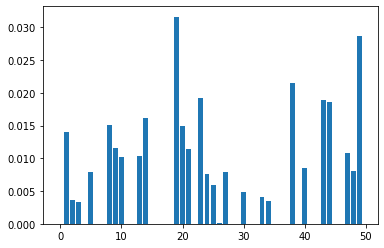

In [ ]:
pyplot.bar([i for i in range(50)], fs_MI.scores_[:50])
pyplot.xlabel("")
pyplot.show()

In [ ]:
#fs = SelectKBest(score_func=mutual_info_classif,k="all")
fs = SelectKBest(k=40)
fs.fit(x_train, y_train)
x_train_fs2 = fs.transform(x_train)
x_test_fs2 = fs.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  150   283   343 ... 14385 14404 14405] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


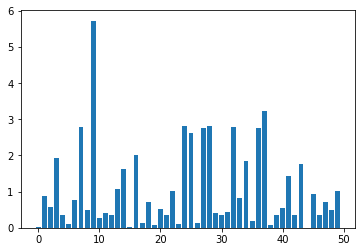

In [ ]:
pyplot.bar([i for i in range(50)], fs.scores_[:50])
pyplot.show()

In [ ]:
work_df

,A1BG,ABCA10,AC002310.5,AC003093.1,AC004485.1,AC004837.2,AC004846.1,AC004917.1,AC005096.1,AC005726.2,...,ZSCAN32_low,ZSCAN32_medium,ZSCAN5C_low,ZSWIM2_low,ZUP1_high,ZUP1_low,ZUP1_medium,ZZEF1_high,ZZEF1_low,ZZEF1_medium
C-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,0,1
C-2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001303,0.0,...,1,0,1,1,0,1,0,0,1,0
C-4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-5,0.191667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-996,0.066667,0.0,0.0,0.0,0.0,0.0,0.003238,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-997,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,0,1
C-998,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0
C-999,0.075000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1,0,1,1,0,1,0,0,1,0


### Baseline models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(3)
neigh.fit(x_train_fs1,y_train)
#neigh.score(x_test_fs1,y_test)
y_hat=neigh.predict(x_test_fs1)
balanced_accuracy_score(y_test,y_hat)

0.5837952588748674

In [ ]:
neigh = KNeighborsClassifier(3)
neigh.fit(x_train_fs2,y_train)
#neigh.score(x_test_fs2,y_test)
y_hat=neigh.predict(x_test_fs2)
balanced_accuracy_score(y_test,y_hat)

0.6331524943979243

In [ ]:
linear_svm=SVC(kernel='linear',degree=5)
linear_svm.fit(x_train_fs2,y_train)
#linear_svm.score(x_test_fs2,y_test)
y_hat=linear_svm.predict(x_test_fs2)
balanced_accuracy_score(y_test,y_hat)

0.6309706333294021

In [ ]:
linear_svm=SVC(kernel='linear')
linear_svm.fit(x_train_fs1,y_train)
#linear_svm.score(x_test_fs1,y_test)
y_hat=linear_svm.predict(x_test_fs1)
balanced_accuracy_score(y_test,y_hat)

0.5173959193301096

In [ ]:
poly_svm=SVC(kernel='poly')
poly_svm.fit(x_train_fs2,y_train)
#poly_svm.score(x_test_fs2,y_test)
y_hat=poly_svm.predict(x_test_fs2)
balanced_accuracy_score(y_test,y_hat)

0.6273735110272438

In [ ]:
poly_svm=SVC(kernel='poly')
poly_svm.fit(x_train_fs1,y_train)
#poly_svm.score(x_test_fs2,y_test)
y_hat=poly_svm.predict(x_test_fs1)
balanced_accuracy_score(y_test,y_hat)

0.5173959193301096

## Model selection

### linear svm with c=5 and 40 kbest features ->**0.6674**

In [ ]:
BCR_linear_svm=[]
for i in range(10):
  #1. SPLIT DATA
  x_train,x_test= train_test_split(work_df,train_size=0.9,shuffle=True)
  y_train =x_train['label']
  x_train.drop('label',axis=1, inplace=True)
  y_test =x_test['label']
  x_test.drop('label',axis=1, inplace=True)

  #Set target label to [0,1]
  output_encoder=LabelEncoder()
  output_encoder.fit(y_train)
  y_train=output_encoder.transform(y_train)
  y_test=output_encoder.transform(y_test)

  #2. FEATURE SELECTION ON TRAIN DATA
  #drop the columns with 0 std
  x_train.drop(x_train.std()[x_train.std() ==0.0].index.values, axis=1,inplace=True)

  #Orderding columns by number of missing values
  Nan_columns=x_train.isnull().sum().sort_values(ascending = False)
  c=list(Nan_columns.index)
  # we drop the columns which have over 10 of missing values
  x_train=x_train.drop(columns=c[:20300])

  # for the remaining columns we fill in the missing values with the mean
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      x_train[i].fillna(value=(x_train[i]).mean(), inplace=True)

  #normalizing numerical features between 0 and 1 
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      denom= (x_train[i].max() - x_train[i].min())
      if (denom != 0):
        x_train[i]= (x_train[i]- x_train[i].min()) / denom

  # creating one hot for categorical data
  x_train=pd.get_dummies(x_train)

  # select K best features based on ANOVA F-score
  fs = SelectKBest(k=20)
  fs.fit(x_train, y_train)
  x_train_fs2 = fs.transform(x_train)

  #3. APPLY MODIFICATION TO TEST DATA
  x_test=pd.get_dummies(x_test)


  col_test= list(x_test.columns)
  col_train=list(x_train.columns)
  drop=np.setdiff1d(col_test,col_train)
  add=np.setdiff1d(col_train,col_test)

  x_test=x_test.drop(drop,axis=1)

  for col in add: 
    x_test[col]=np.zeros(x_test.shape[0])

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      x_test[i].fillna(value=x_test[i].mean(), inplace=True)

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      denom= (x_test[i].max() - x_test[i].min())
      if (denom != 0):
        x_test[i]= (x_test[i]- x_test[i].min()) / denom

  x_test=x_test[list(x_train.columns)]

  x_test_fs2=fs.transform(x_test)
  #4. MODEL
  linear_svm=SVC(kernel='linear',C=5,random_state=42)
  linear_svm.fit(x_train_fs2,y_train)
  #linear_svm.score(x_test_fs2,y_test)
  y_hat=linear_svm.predict(x_test_fs2)
  BCR_linear_svm.append(balanced_accuracy_score(y_test,y_hat))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   53    85    86 ... 13050 13069 13070] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fra

In [ ]:
np.sum(BCR_linear_svm)/len(BCR_linear_svm)

0.6674900310365335

### poly svm with c=10 and 100 kbest features -> **0.6549**

In [ ]:
BCR_poly_svm=[]
for i in range(10):
  #1. SPLIT DATA
  x_train,x_test= train_test_split(work_df,train_size=0.9,shuffle=True)
  y_train =x_train['label']
  x_train.drop('label',axis=1, inplace=True)
  y_test =x_test['label']
  x_test.drop('label',axis=1, inplace=True)

  #Set target label to [0,1]
  #output_encoder=LabelEncoder()
  #output_encoder.fit(y_train)
  #y_train=output_encoder.transform(y_train)
  #y_test=output_encoder.transform(y_test)

  #2. FEATURE SELECTION ON TRAIN DATA
  #drop the columns with 0 std
  x_train.drop(x_train.std()[x_train.std() ==0.0].index.values, axis=1,inplace=True)

  constant_categorical=[]
  for col in list(x_train.columns):
    if (x_train[col].dtype =='object') and (x_train[col].nunique()<2):
      constant_categorical.append(col)
  x_train=x_train.drop(constant_categorical,axis=1)

  #Orderding columns by number of missing values
  Nan_columns=x_train.isnull().sum().sort_values(ascending = False)
  c=list(Nan_columns.index)
  # we drop the columns which have over 10 of missing values
  x_train=x_train.drop(columns=c[:20300])

  # for the remaining columns we fill in the missing values with the mean
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      x_train[i].fillna(value=(x_train[i]).median(), inplace=True)

  #normalizing numerical features between 0 and 1 
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      denom= (x_train[i].max() - x_train[i].min())
      if (denom != 0):
        x_train[i]= (x_train[i]- x_train[i].min()) / denom

  # creating one hot for categorical data
  x_train=pd.get_dummies(x_train)

  #removing correlated features

  correlation_matrix = x_train.corr().abs()

  correlated_features = []
  for i, col in enumerate(correlation_matrix.columns):
      if col in correlated_features: 
          continue
      for j, row in enumerate(correlation_matrix.columns[i+1:]):
          if correlation_matrix[col][row] >= 0.9:
              correlated_features.append(row)

  correlated_features = np.unique(correlated_features)
  x_train = x_train.drop(columns=correlated_features)

  col_train=list(x_train.columns)
  # feature extraction
  pca= PCA()
  x_train=pca.fit_transform(x_train)

  sm = SMOTE(random_state = 42)
  x_train, y_train = sm.fit_resample(x_train, y_train)
  # select K best features based on ANOVA F-score
  fs = SelectKBest(k=150)
  fs.fit(x_train, y_train)
  x_train_fs2 = fs.transform(x_train)

  #3. APPLY MODIFICATION TO TEST DATA
  x_test=pd.get_dummies(x_test)


  col_test= list(x_test.columns)
  drop=np.setdiff1d(col_test,col_train)
  add=np.setdiff1d(col_train,col_test)

  x_test=x_test.drop(drop,axis=1)

  for col in add: 
    x_test[col]=np.zeros(x_test.shape[0])

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      x_test[i].fillna(value=x_test[i].median(), inplace=True)

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      denom= (x_test[i].max() - x_test[i].min())
      if (denom != 0):
        x_test[i]= (x_test[i]- x_test[i].min()) / denom

  x_test=x_test[col_train]
  x_test=pca.transform(x_test)
  x_test_fs2=fs.transform(x_test)
  #4. MODEL
  linear_svm=SVC(kernel='poly',degree=3,C=10,gamma=1,coef0=0.01)
  linear_svm.fit(x_train_fs2,y_train)
  #linear_svm.score(x_test_fs2,y_test)
  y_hat=linear_svm.predict(x_test_fs2)
  BCR_poly_svm.append(balanced_accuracy_score(y_test,y_hat))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feat

In [ ]:
np.sum(BCR_poly_svm)/len(BCR_poly_svm)

0.7556149501147318

In [ ]:
BCR_poly_svm

[0.7739192062367115,
 0.7358674463937622,
 0.7609126984126984,
 0.825657894736842,
 0.7023809523809523,
 0.6321321321321322,
 0.8109756097560976,
 0.7214285714285715,
 0.740893637688198,
 0.8519813519813519]

In [ ]:
conf=[{'C':1,'degree':3,'gamma':'scale','coef0':0},{'C':10,'degree':4,'gamma':'scale','coef0':0}]

### Random Forest


In [ ]:
BCR_RF=[]
min_samp=[2,10,40,50,100,120,150,200]
max_depth=[2,5,10,15,20,50,100]
min_leaf=[1,2,5,10]
results=[]
for i in range(10):
  #1. SPLIT DATA
  x_train,x_test= train_test_split(work_df,train_size=0.9,shuffle=True)
  y_train =x_train['label']
  x_train.drop('label',axis=1, inplace=True)
  y_test =x_test['label']
  x_test.drop('label',axis=1, inplace=True)

  #Set target label to [0,1]
  output_encoder=LabelEncoder()
  output_encoder.fit(y_train)
  y_train=output_encoder.transform(y_train)
  y_test=output_encoder.transform(y_test)

  #2. FEATURE SELECTION ON TRAIN DATA
  #drop the columns with 0 std and unique categorical value
  x_train.drop(x_train.std()[x_train.std() ==0.0].index.values, axis=1,inplace=True)
  constant_categorical=[]
  for col in list(x_train.columns):
    if (x_train[col].dtype =='object') and (x_train[col].nunique()<2):
      constant_categorical.append(col)
  x_train=x_train.drop(constant_categorical,axis=1)
  #Orderding columns by number of missing values
  Nan_columns=x_train.isnull().sum().sort_values(ascending = False)
  c=list(Nan_columns.index)
  # we drop the columns which have over 10 of missing values
  x_train=x_train.drop(columns=c[:20300])

  # for the remaining columns we fill in the missing values with the mean
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      x_train[i].fillna(value=(x_train[i]).median(), inplace=True)

  #normalizing numerical features between 0 and 1 
  for i in list(x_train.columns):
    if(x_train[i].dtype != 'object'):
      denom= (x_train[i].max() - x_train[i].min())
      if (denom != 0):
        x_train[i]= (x_train[i]- x_train[i].min()) / denom

  # creating one hot for categorical data
  x_train=pd.get_dummies(x_train)


  sm = SMOTE(random_state = 42)
  x_train, y_train = sm.fit_resample(x_train, y_train)
  # select K best features based on ANOVA F-score
  fs = SelectKBest(k=200)
  fs.fit(x_train, y_train)
  x_train_fs2 = fs.transform(x_train)

  #3. APPLY MODIFICATION TO TEST DATA
  x_test=pd.get_dummies(x_test)


  col_test= list(x_test.columns)
  col_train=list(x_train.columns)
  drop=np.setdiff1d(col_test,col_train)
  add=np.setdiff1d(col_train,col_test)

  x_test=x_test.drop(drop,axis=1)

  for col in add: 
    x_test[col]=np.zeros(x_test.shape[0])

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      x_test[i].fillna(value=x_test[i].median(), inplace=True)

  for i in list(x_test.columns):
    if(x_test[i].dtype != 'object'):
      denom= (x_test[i].max() - x_test[i].min())
      if (denom != 0):
        x_test[i]= (x_test[i]- x_test[i].min()) / denom

  x_test=x_test[list(x_train.columns)]

  x_test_fs2=fs.transform(x_test)
  #4. MODEL
  #y_hat=poly_svm.predict(x_test_fs2)
  best_forest=RandomForestClassifier(200,min_samples_split=40,max_depth=10,min_samples_leaf=10,random_state=0) 
  best_forest.fit(x_train_fs2,y_train)
  y_hat=best_forest.predict(x_test_fs2)
  BCR_RF.append(balanced_accuracy_score(y_test,y_hat))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SelectKBest was fitted w

In [ ]:
np.sum(BCR_RF)/len(BCR_RF)

0.6260598879660816

In [ ]:
BCR_RF

[0.6333333333333333,
 0.6125,
 0.6440524649479873,
 0.6666666666666666,
 0.6959689169499756,
 0.6133333333333333,
 0.5942460317460317,
 0.5800000000000001,
 0.6261998870694523,
 0.5942982456140351]

### Finetune RF

In [ ]:

c1=[]
c2=[]
c3=[]
c4=[]
for m in min_samp:
  for dep in max_depth:
    for leaf in min_leaf:
      BCR_RF=[]
      for i in range(10):
     
        #1. SPLIT DATA
        x_train,x_test= train_test_split(work_df,train_size=0.9,shuffle=True)
        y_train =x_train['label']
        x_train.drop('label',axis=1, inplace=True)
        y_test =x_test['label']
        x_test.drop('label',axis=1, inplace=True)
    
        #Set target label to [0,1]
        output_encoder=LabelEncoder()
        output_encoder.fit(y_train)
        y_train=output_encoder.transform(y_train)
        y_test=output_encoder.transform(y_test)
      
        #2. FEATURE SELECTION ON TRAIN DATA
        #drop the columns with 0 std
        x_train.drop(x_train.std()[x_train.std() ==0.0].index.values, axis=1,inplace=True)
       
        #Orderding columns by number of missing values
        Nan_columns=x_train.isnull().sum().sort_values(ascending = False)
        c=list(Nan_columns.index)
       
        # we drop the columns which have over 10 of missing values
        x_train=x_train.drop(columns=c[:20300])
       
       
       # for the remaining columns we fill in the missing values with the mean
        for i in list(x_train.columns):
          if(x_train[i].dtype != 'object'):
            x_train[i].fillna(value=(x_train[i]).mean(), inplace=True)
       
        #normalizing numerical features between 0 and 1 
        for i in list(x_train.columns):
          if(x_train[i].dtype != 'object'):
            denom= (x_train[i].max() - x_train[i].min())
            if (denom != 0):
              x_train[i]= (x_train[i]- x_train[i].min()) / denom
      
        # creating one hot for categorical data
        x_train=pd.get_dummies(x_train)
        sm = SMOTE(random_state = 42)
        x_train, y_train = sm.fit_resample(x_train, y_train)
        
        # select K best features based on ANOVA F-score
        fs = SelectKBest(k=200)
        fs.fit(x_train, y_train)
        x_train_fs2 = fs.transform(x_train)

        #3. APPLY MODIFICATION TO TEST DATA
        x_test=pd.get_dummies(x_test)
        col_test= list(x_test.columns)
        col_train=list(x_train.columns)
        drop=np.setdiff1d(col_test,col_train)
        add=np.setdiff1d(col_train,col_test)

        x_test=x_test.drop(drop,axis=1)
        for col in add: 
          x_test[col]=np.zeros(x_test.shape[0])
        for i in list(x_test.columns):
          if(x_test[i].dtype != 'object'):
            x_test[i].fillna(value=x_test[i].mean(), inplace=True)
        for i in list(x_test.columns):
          if(x_test[i].dtype != 'object'):
            denom= (x_test[i].max() - x_test[i].min())
            if (denom != 0):
              x_test[i]= (x_test[i]- x_test[i].min()) / denom
        x_test=x_test[list(x_train.columns)]
        x_test_fs2=fs.transform(x_test)

        #4. MODEL
        #y_hat=poly_svm.predict(x_test_fs2)
        best_forest=RandomForestClassifier(100,min_samples_split=m,max_depth=dep,min_samples_leaf=leaf,random_state=0)
        best_forest.fit(x_train_fs2,y_train)
        y_hat=best_forest.predict(x_test_fs2)
        BCR_RF.append(balanced_accuracy_score(y_test,y_hat))
      results.append(np.sum(BCR_RF)/len(BCR_RF))
      c1.append(m)
      c2.append(dep)
      c3.append(leaf)
      #c4.append(s)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   55    88    89 ... 12936 12955 12956] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature n

In [ ]:
frame_best_tree=pd.DataFrame(columns=['min_sample_split','min_sample_leaf','max_depth','TestAcc'])
frame_best_tree['min_sample_split']=c1
frame_best_tree['max_depth']=c2
frame_best_tree['min_sample_leaf']=c3
frame_best_tree['TestAcc']=results
frame_best_tree

In [ ]:
work_df['Z84723.1'].unique()

array(['low'], dtype=object)

In [ ]:
constant_categorical=[]
for col in list(work_df.columns):
  if (work_df[col].dtype =='object') and (work_df[col].nunique()<2):
    constant_categorical.append(col)

ABCA9-AS1
AC000085.1
AC000362.1
AC000367.1
AC002044.2
AC002057.2
AC002066.1
AC002074.1
AC002115.1
AC002401.2
AC002984.1
AC003005.2
AC003685.1
AC003950.1
AC003975.1
AC004009.2
AC004012.1
AC004014.2
AC004047.1
AC004112.1
AC004147.3
AC004217.2
AC004223.1
AC004231.1
AC004233.1
AC004453.2
AC004461.1
AC004494.2
AC004678.1
AC004817.2
AC004828.1
AC004866.2
AC004870.1
AC004888.1
AC004899.1
AC004923.2
AC004986.1
AC005005.1
AC005009.2
AC005019.2
AC005034.4
AC005050.3
AC005186.1
AC005303.1
AC005341.1
AC005343.4
AC005355.2
AC005394.2
AC005523.1
AC005586.2
AC005618.4
AC005666.1
AC005702.5
AC005736.2
AC005740.4
AC005832.4
AC005858.3
AC005972.2
AC005999.1
AC005999.2
AC006001.1
AC006020.1
AC006111.3
AC006213.4
AC006238.1
AC006386.2
AC006435.1
AC006452.1
AC006457.1
AC006483.2
AC006487.1
AC006504.6
AC006509.1
AC006538.2
AC006538.5
AC006967.3
AC007012.2
AC007106.1
AC007128.2
AC007218.1
AC007221.1
AC007326.2
AC007326.3
AC007326.5
AC007381.1
AC007391.1
AC007450.2
AC007485.1
AC007556.1
AC007599.2
AC007620.1


## Predictions

In [ ]:
x_test=final_test_df
x_test=pd.get_dummies(x_test)

col_test= list(x_test.columns)
#col_train=list(x_train.columns)
drop=np.setdiff1d(col_test,col_train)
add=np.setdiff1d(col_train,col_test)


x_test=x_test.drop(drop,axis=1)

for col in add: 
  x_test[col]=np.zeros(x_test.shape[0])

for i in list(x_test.columns):
  if(x_test[i].dtype != 'object'):
    x_test[i].fillna(value=x_test[i].median(), inplace=True)

for i in list(x_test.columns):
  if(x_test[i].dtype != 'object'):
    denom= (x_test[i].max() - x_test[i].min())
    if (denom != 0):
      x_test[i]= (x_test[i]- x_test[i].min()) / denom

x_test=x_test[col_train]
x_test=x_test[col_train]
x_test=pca.transform(x_test)
x_test_fs2=fs.transform(x_test)
#4. MODEL
#linear_svm=SVC(kernel='linear',C=3,random_state=42)
#linear_svm.fit(x_train_fs2,y_train)
#linear_svm.score(x_test_fs2,y_test)
y_hat=linear_svm.predict(x_test_fs2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
result_df=pd.DataFrame(y_hat,columns=['Prediction'], index=list(final_test_df.index))

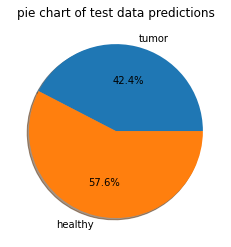

In [ ]:
count=result_df['Prediction'].value_counts()
plt.pie([count[1],count[0]],labels=['tumor','healthy'],autopct='%1.1f%%',shadow=True)
plt.title("pie chart of test data predictions",loc='center')
plt.show()

In [ ]:
# 1 = tumor and 0 = healthy 
# 1   tumor cells, -1 for the healthy

,Prediction
C-1001,0
C-1002,1
C-1003,1
C-1004,1
C-1005,0
...,...
C-1496,1
C-1497,0
C-1498,0
C-1499,1


In [ ]:
for i in range(500): 
  if result_df.iloc[i,0]==0: 
    result_df.iloc[i,0]=-1

In [ ]:
result_df

,Prediction
C-1001,-1
C-1002,1
C-1003,1
C-1004,1
C-1005,-1
...,...
C-1496,1
C-1497,-1
C-1498,-1
C-1499,1


In [ ]:
verif=pd.read_csv("/content/LINFO2262_prediction_result.csv")

In [ ]:
verif

,Unnamed: 0,Prediction
0,C-1001,-1
1,C-1002,1
2,C-1003,1
3,C-1004,1
4,C-1005,-1
...,...,...
495,C-1496,1
496,C-1497,-1
497,C-1498,-1
498,C-1499,1


In [ ]:
work_df['label']

C-1      -1
C-2      -1
C-3      -1
C-4      -1
C-5       1
         ..
C-996    -1
C-997    -1
C-998    -1
C-999    -1
C-1000    1
Name: label, Length: 1000, dtype: int64

In [ ]:
y_train=work_df['label']
le= LabelEncoder()
out=le.fit_transform(y_train)

In [ ]:
out
#-1 devient 0 
# 1 devient 1 

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,